In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

DATA_PATH = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

# Get all valid image paths
all_img_paths = []
all_mask_paths = []

for patient in os.listdir(DATA_PATH):
    patient_path = os.path.join(DATA_PATH, patient)
    if not os.path.isdir(patient_path):
        continue
    
    for file in os.listdir(patient_path):
        if '_mask' not in file:
            img_path = os.path.join(patient_path, file)
            mask_path = img_path.replace('.tif', '_mask.tif')
            
            # Quick check if files exist and can be read
            if os.path.exists(mask_path):
                all_img_paths.append(img_path)
                all_mask_paths.append(mask_path)

print(f"Found {len(all_img_paths)} image-mask pairs")

2025-10-08 16:12:42.690877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759939963.208464      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759939963.325463      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 3929 image-mask pairs


=== DATA DIAGNOSTIC ===

Sample image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
Sample mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif

Image shape: (256, 256)
Image min/max: 0/203
Mask shape: (256, 256)
Mask min/max: 0/255
Mask unique values: [  0 255]


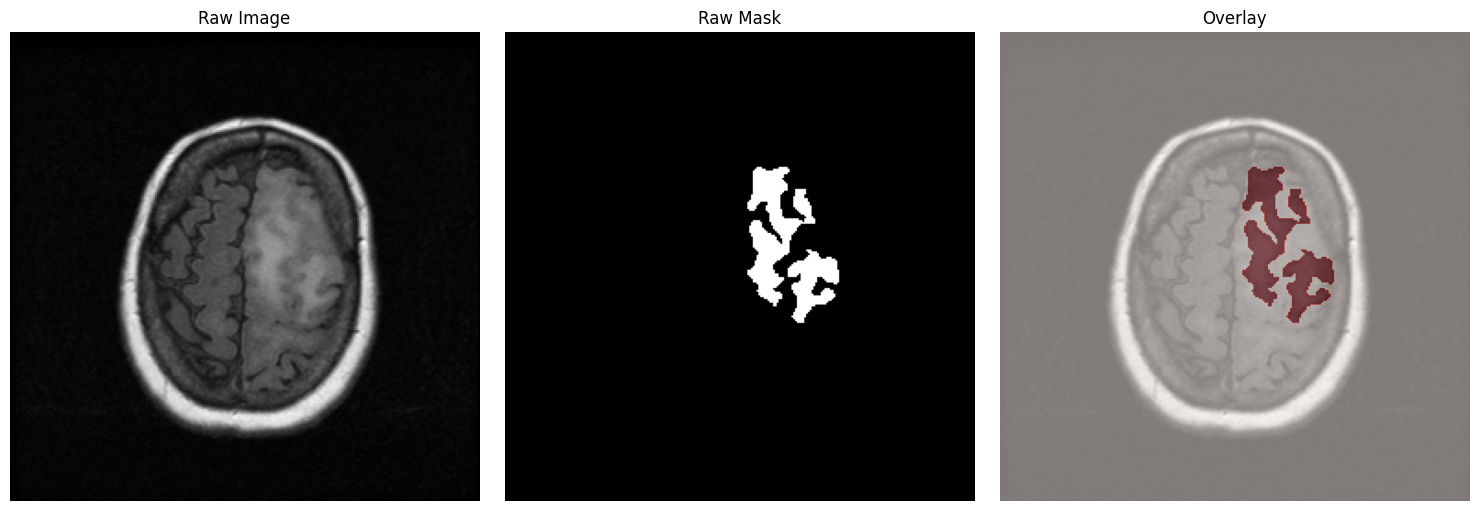


Tumor pixels in mask: 1863
Tumor percentage: 2.84%


In [2]:
# Let's see what we actually have
print("=== DATA DIAGNOSTIC ===\n")

# Check one sample file directly
sample_img_path = all_img_paths[0]
sample_mask_path = all_mask_paths[0]

print(f"Sample image: {sample_img_path}")
print(f"Sample mask: {sample_mask_path}")

# Load and inspect
img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

print(f"\nImage shape: {img.shape}")
print(f"Image min/max: {img.min()}/{img.max()}")
print(f"Mask shape: {mask.shape}")
print(f"Mask min/max: {mask.min()}/{mask.max()}")
print(f"Mask unique values: {np.unique(mask)}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Raw Image')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Raw Mask')
axes[1].axis('off')

axes[2].imshow(img, cmap='gray')
axes[2].imshow(mask, alpha=0.5, cmap='Reds')
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Check if we have tumor in mask
tumor_pixels = (mask > 0).sum()
print(f"\nTumor pixels in mask: {tumor_pixels}")
print(f"Tumor percentage: {tumor_pixels / mask.size * 100:.2f}%")

In [3]:
IMG_SIZE = 128  # Using 128 instead of 256 to save memory

X_all = []
y_all = []
failed = 0

for i, (img_path, mask_path) in enumerate(zip(all_img_paths, all_mask_paths)):
    try:
        # Load
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            failed += 1
            continue

        if i <=0:
            print(f"Image path: {img_path}")
            print(f"Mask path: {mask_path}")
            
            print(f"\nBefore processing:")
            print(f"  Image shape: {img.shape}")
            print(f"  Image dtype: {img.dtype}")
            print(f"  Image min/max: {img.min()}/{img.max()}")
            print(f"  Mask shape: {mask.shape}")
            print(f"  Mask min/max: {mask.min()}/{mask.max()}")
            
            print(f"\nImage array (center 5x5 pixels):")
            center = img.shape[0] // 2
            print(img[center:center+5, center:center+5])
            
            print(f"\nMask array (center 5x5 pixels):")
            print(mask[center:center+5, center:center+5])
            
        
        # Resize
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        if i <=0:
            print(f"\nAfter Resizing:")
            print(f"  Image shape: {img.shape}")
            print(f"  Image dtype: {img.dtype}")
            print(f"  Image min/max: {img.min()}/{img.max()}")
            print(f"  Mask shape: {mask.shape}")
            print(f"  Mask min/max: {mask.min()}/{mask.max()}")

            print(f"\nImage array (center 5x5 pixels):")
            center = img.shape[0] // 2
            print(img[center:center+5, center:center+5])
            
            print(f"\nMask array (center 5x5 pixels):")
            print(mask[center:center+5, center:center+5])
            
        
        # Normalize
        img = img.astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)

        if i <=0:
            print(f"\nAfter No:")
            print(f"  Image shape: {img.shape}")
            print(f"  Image dtype: {img.dtype}")
            print(f"  Image min/max: {img.min()}/{img.max()}")
            print(f"  Mask shape: {mask.shape}")
            print(f"  Mask min/max: {mask.min()}/{mask.max()}")

            print(f"\nImage array (center 5x5 pixels):")
            center = img.shape[0] // 2
            print(img[center:center+5, center:center+5])
            
            print(f"\nMask array (center 5x5 pixels):")
            print(mask[center:center+5, center:center+5])
        
        X_all.append(img)
        y_all.append(mask)
        
    except:
        failed += 1

Image path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
Mask path: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45_mask.tif

Before processing:
  Image shape: (256, 256)
  Image dtype: uint8
  Image min/max: 0/203
  Mask shape: (256, 256)
  Mask min/max: 0/255

Image array (center 5x5 pixels):
[[ 57  74  77  81  90]
 [ 62  78  82  88  97]
 [ 62  73  81  93 101]
 [ 65  72  77  88  95]
 [ 68  72  76  86  92]]

Mask array (center 5x5 pixels):
[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0 255]
 [  0   0   0   0 255]
 [  0   0   0   0 255]]

After Resizing:
  Image shape: (128, 128)
  Image dtype: uint8
  Image min/max: 0/190
  Mask shape: (128, 128)
  Mask min/max: 0/255

Image array (center 5x5 pixels):
[[ 68  82  96 102 109]
 [ 68  85  99 104 112]
 [ 70  79  90  98 109]
 [ 61  74  78  93 108]
 [ 48  66  71  85 101]]

Mask array (center 5x5 pixels):
[[  0   0   0 191 255]
 [  

In [4]:
# Convert to arrays
X_all = np.array(X_all)
y_all = np.array(y_all)

# Add channel dimension
X_all = np.expand_dims(X_all, axis=-1)
y_all = np.expand_dims(y_all, axis=-1)

print(f"\nLoaded {len(X_all)} images successfully")
print(f"Failed: {failed}")
print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")


Loaded 3929 images successfully
Failed: 0
X_all shape: (3929, 128, 128, 1)
y_all shape: (3929, 128, 128, 1)


In [5]:
# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

# Verify data looks good
print(f"\n Data ranges:")
print(f"X_train: {X_train.min():.3f} to {X_train.max():.3f}")
print(f"y_train: {y_train.min():.3f} to {y_train.max():.3f}")

Train: (2750, 128, 128, 1)
Val: (589, 128, 128, 1)
Test: (590, 128, 128, 1)

 Data ranges:
X_train: 0.000 to 0.918
y_train: 0.000 to 1.000


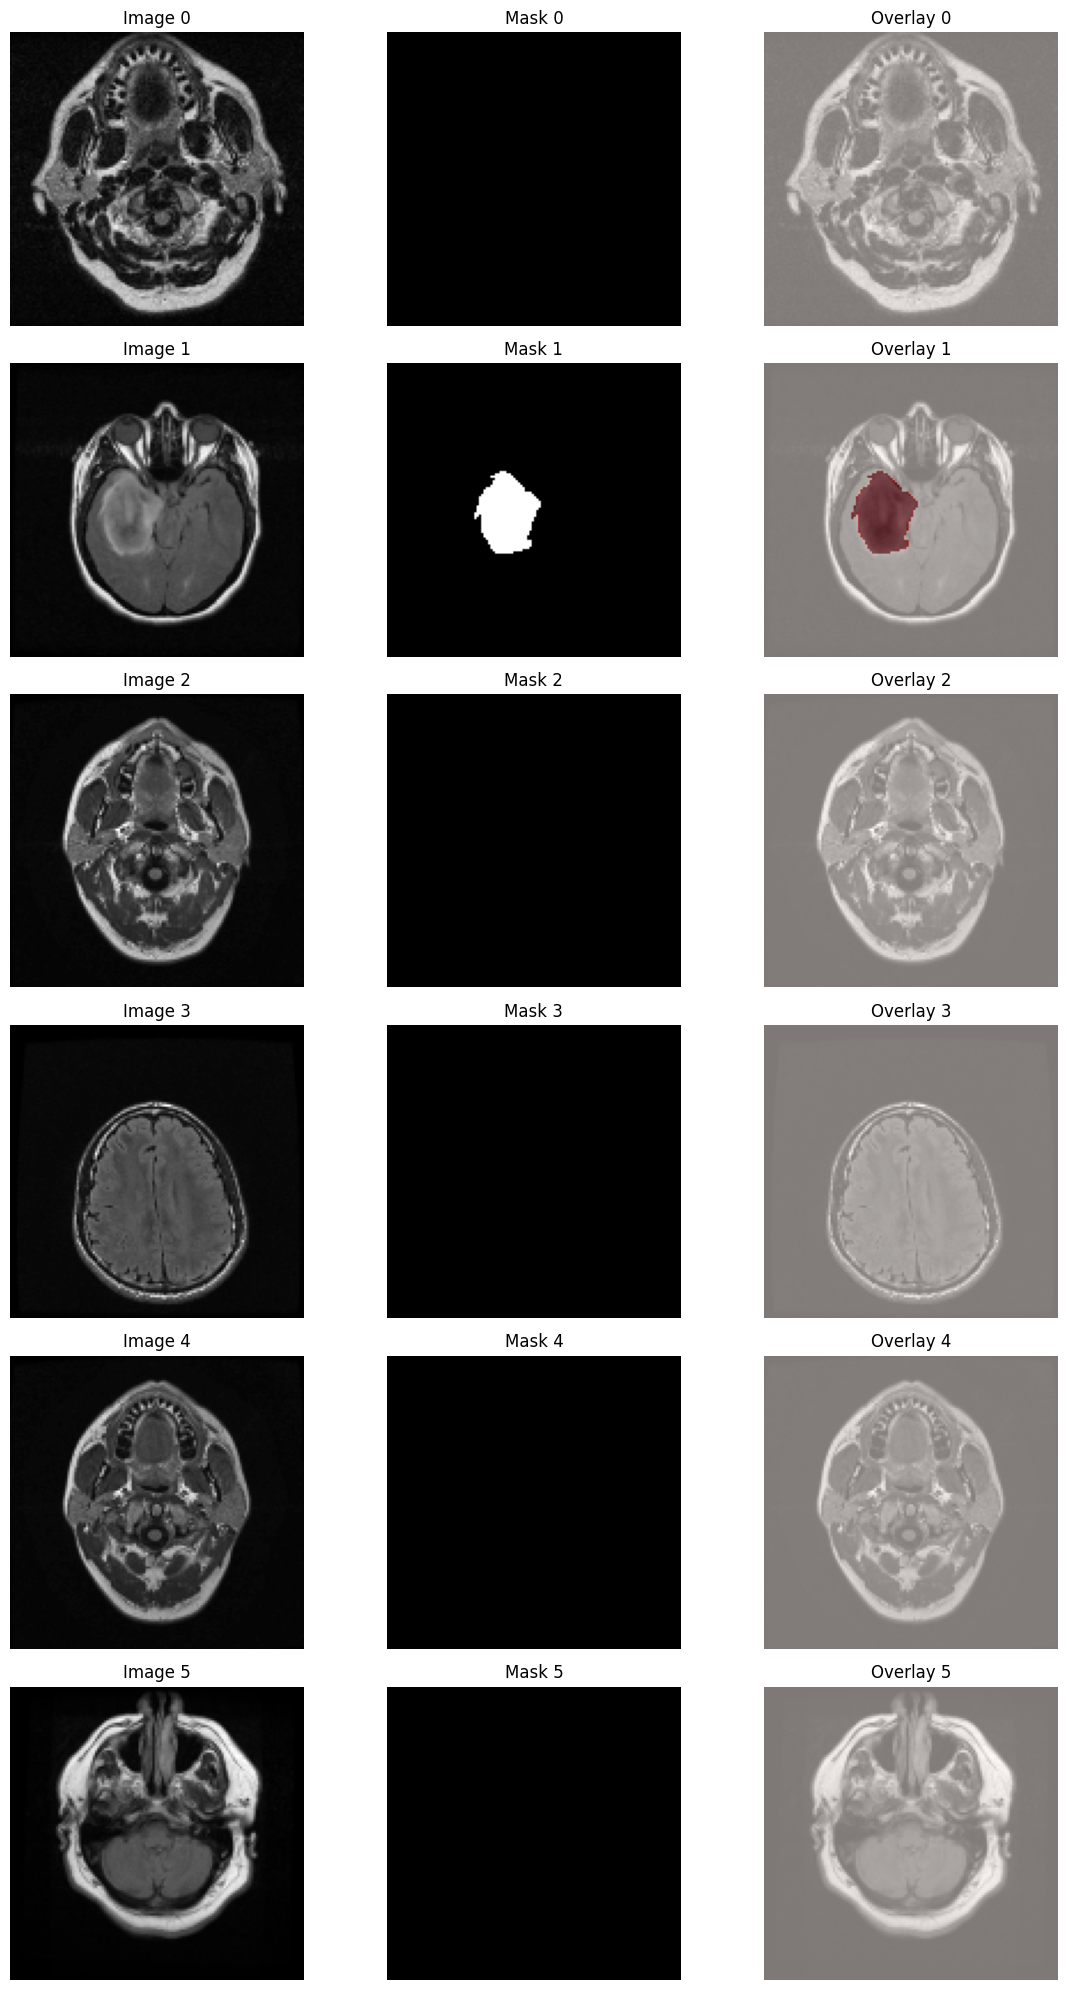

In [6]:
# Visualize first 6 samples
fig, axes = plt.subplots(6, 3, figsize=(12, 20))

for i in range(6):
    axes[i, 0].imshow(X_train[i].squeeze(), cmap='gray')
    axes[i, 0].set_title(f'Image {i}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(y_train[i].squeeze(), cmap='gray')
    axes[i, 1].set_title(f'Mask {i}')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(X_train[i].squeeze(), cmap='gray')
    axes[i, 2].imshow(y_train[i].squeeze(), alpha=0.5, cmap='Reds')
    axes[i, 2].set_title(f'Overlay {i}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [7]:
def build_unet_fixed():
    inputs = layers.Input(shape=(128, 128, 1))
    
    # Encoder
    c1 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D(2)(c1)
    
    c2 = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D(2)(c2)
    
    c3 = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D(2)(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    
    # Decoder
    u5 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    
    u6 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    
    u7 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    
    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid', kernel_initializer='glorot_uniform')(c7)
    
    return models.Model(inputs, outputs)

# Build NEW model
model = build_unet_fixed()
print("U-Net built with Batch Normalization!")

I0000 00:00:1759940115.082595      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759940115.083257      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


U-Net built with Batch Normalization!


In [8]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    # Binary crossentropy + Dice loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=combined_loss,
    metrics=[dice_coefficient]
)

print("Model compiled with combined loss!")

Model compiled with combined loss!


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_dice_coefficient',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=15,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print("Training on FULL dataset...")
print("Target: Dice > 0.85\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print("\nTraining complete!")

Training on FULL dataset...
Target: Dice > 0.85

Epoch 1/50


I0000 00:00:1759940131.531333      67 service.cc:148] XLA service 0x7d6188039060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759940131.533210      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759940131.533234      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759940133.016423      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/86 ━━━━━━━━━━━━━━━━━━━━ 43:20 31s/step - dice_coefficient: 0.0467 - loss: 1.8802

I0000 00:00:1759940148.786383      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - dice_coefficient: 0.0368 - loss: 1.3852
Epoch 1: val_dice_coefficient improved from -inf to 0.04433, saving model to best_model.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 60s 346ms/step - dice_coefficient: 0.0370 - loss: 1.3833 - val_dice_coefficient: 0.0443 - val_loss: 1.2361 - learning_rate: 0.0010
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - dice_coefficient: 0.1153 - loss: 1.0055
Epoch 2: val_dice_coefficient improved from 0.04433 to 0.12509, saving model to best_model.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - dice_coefficient: 0.1156 - loss: 1.0050 - val_dice_coefficient: 0.1251 - val_loss: 1.0482 - learning_rate: 0.0010
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - dice_coefficient: 0.2739 - loss: 0.7835
Epoch 3: val_dice_coefficient improved from 0.12509 to 0.17671, saving model to best_model.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - dice_coefficient: 0.2744 - loss: 0.7830 - val_dice_coefficient: 0.1767 - val_loss: 0.8736 

In [10]:
# Load best model
best_model = tf.keras.models.load_model(
    'best_model.h5',
    custom_objects={
        'combined_loss': combined_loss,
        'dice_coefficient': dice_coefficient
    }
)

print(f"Total test images: {len(X_test)}")
print(f"Test set shape: {X_test.shape}")

# Evaluate on test set
print(" Evaluating on Test Set\n")
test_results = best_model.evaluate(X_test, y_test, verbose=1)

print(f"FINAL TEST RESULTS")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice Coefficient: {test_results[1]:.4f}")

Total test images: 590
Test set shape: (590, 128, 128, 1)
 Evaluating on Test Set

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - dice_coefficient: 0.8537 - loss: 0.1648
FINAL TEST RESULTS
Test Loss: 0.1774
Test Dice Coefficient: 0.8361


 Visualizing Predictions...



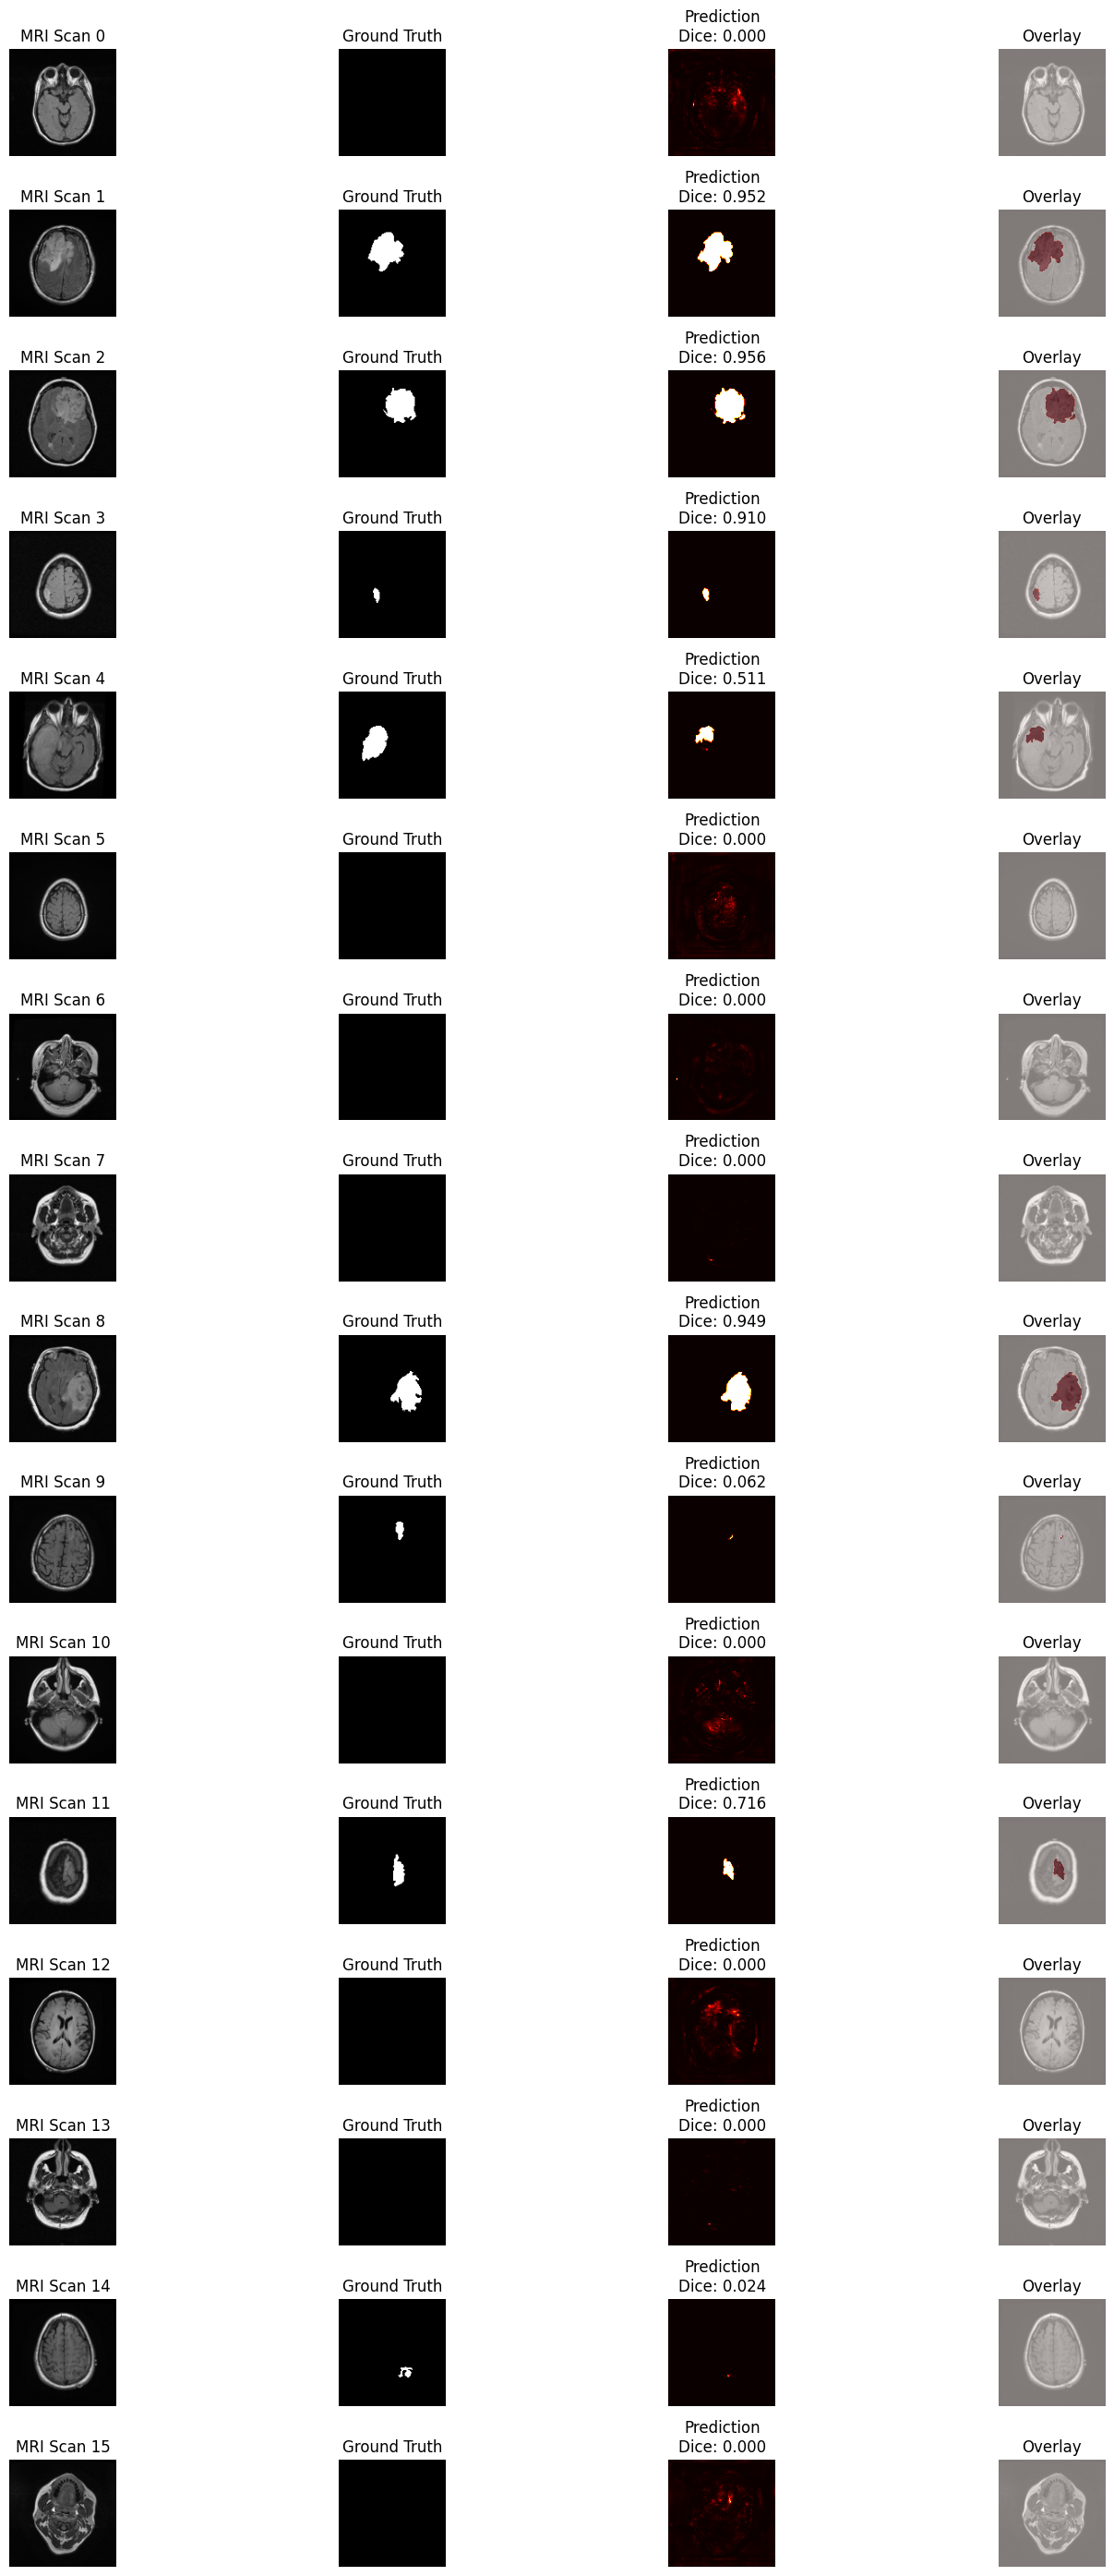

In [11]:
# Visualize predictions on test set
print(" Visualizing Predictions...\n")

# Get predictions
predictions = best_model.predict(X_test[:16], verbose=0)

# Plot
fig, axes = plt.subplots(16, 4, figsize=(16, 28))

for i in range(16):
    # Calculate dice for this sample
    dice_score = dice_coefficient(
        y_test[i:i+1], 
        predictions[i:i+1]
    ).numpy()
    
    # Original image
    axes[i, 0].imshow(X_test[i].squeeze(), cmap='gray')
    axes[i, 0].set_title(f'MRI Scan {i}')
    axes[i, 0].axis('off')
    
    # Ground truth
    axes[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    # Prediction
    axes[i, 2].imshow(predictions[i].squeeze(), cmap='hot')
    axes[i, 2].set_title(f'Prediction\nDice: {dice_score:.3f}')
    axes[i, 2].axis('off')
    
    # Overlay
    axes[i, 3].imshow(X_test[i].squeeze(), cmap='gray')
    axes[i, 3].imshow(predictions[i].squeeze() > 0.5, alpha=0.5, cmap='Reds')
    axes[i, 3].set_title('Overlay')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()

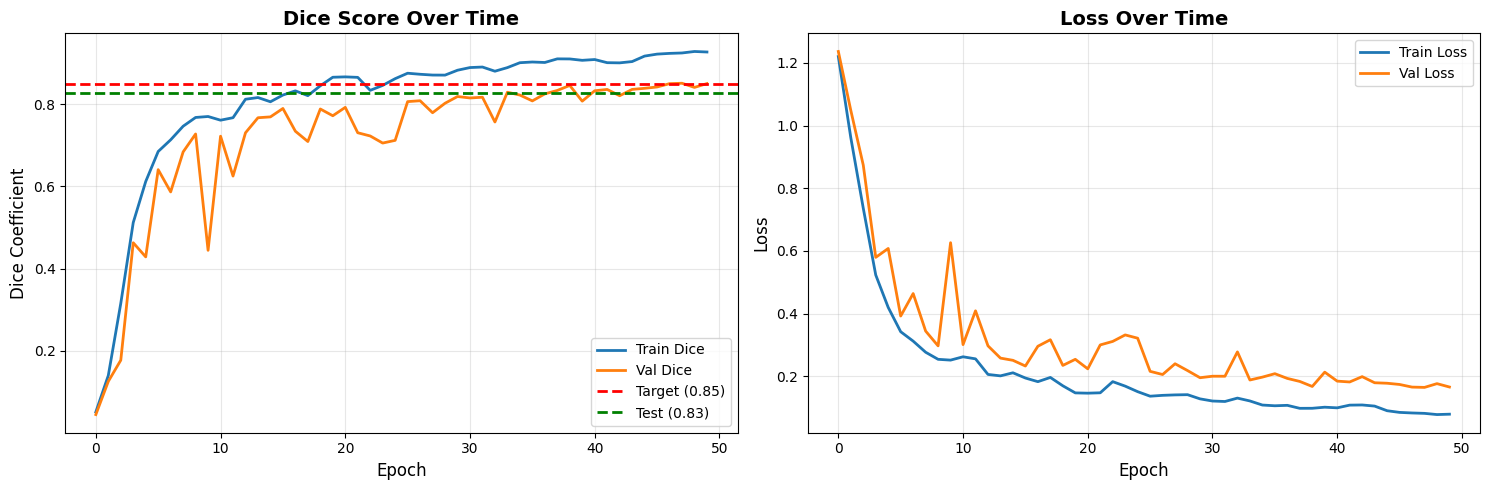

In [12]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Dice Score
axes[0].plot(history.history['dice_coefficient'], label='Train Dice', linewidth=2)
axes[0].plot(history.history['val_dice_coefficient'], label='Val Dice', linewidth=2)
axes[0].axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Target (0.85)')
axes[0].axhline(y=0.8283, color='green', linestyle='--', linewidth=2, label='Test (0.83)')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Dice Coefficient', fontsize=12)
axes[0].set_title('Dice Score Over Time', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
print("\n" + "="*60)
print("PROJECT SUMMARY: BRAIN TUMOR SEGMENTATION")
print("="*60)
print(f"Model: U-Net with Batch Normalization")
print(f"Dataset: {len(X_all)} brain MRI images")
print(f"Training Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")
print(f"Test Samples: {len(X_test)}")
print(f"\nFinal Results:")
print(f"  Test Dice Score: {test_results[1]:.4f}")


PROJECT SUMMARY: BRAIN TUMOR SEGMENTATION
Model: U-Net with Batch Normalization
Dataset: 3929 brain MRI images
Training Samples: 2750
Validation Samples: 589
Test Samples: 590

Final Results:
  Test Dice Score: 0.8361
